## 简答题

1. TensorFlow 是否可以简单替代 NumPy？两者之间的主要区别是什么？

2. 使用 `tf.range(10)` 和 `tf.constant(np.arange(10))` 是否会得到相同的结果？

3. 可以通过编写函数或继承 `tf.keras.losses.Loss` 来定义自定义损失函数。两种方法分别应该在什么时候使用？

4. 可以直接在函数中定义自定义指标或采用 `tf.keras.metrics.Metric` 子类。两种方法分别应该在什么时候使用？

5. 什么时候应该自定义层而不是自定义模型？

6. 有哪些示例需要编写自定义训练循环？

7. 自定义 Keras 组件中可以包含任意 Python 代码，还是必须转换为 TF 函数？

8. 如果要将函数转换为 TF 函数，应避免哪些主要模式？

9. 何时需要创建动态 Keras 模型？ 如何动态创建Keras模型？为什么不是所有模型都动态化？


In [ ]:
# 1：不能简单替代，核心区别在于设计目标和功能：
# NumPy：专注于通用数值计算（矩阵运算、线性代数等），运行在 CPU 上，无自动微分、 GPU 加速（需额外库）或计算图功能，适合科学计算和数据预处理。
# TensorFlow：深度学习框架，支持 GPU/TPU 加速、自动微分、计算图（静态 / 动态）、分布式训练等，其张量操作与 NumPy 类似，但更侧重机器学习工作流（模型构建、训练、部署）。
# TensorFlow 可替代 NumPy 的部分数值计算功能，但前者依赖更多资源，且 NumPy 在非深度学习场景中更轻量高效
# 2：数值结果相同
# 3：函数式定义：适合简单逻辑（仅依赖y_true和y_pred），如自定义 MSE 变种。
# 继承 tf.keras.losses.Loss：适合需要保存状态或复杂逻辑的场景，如依赖外部参数、需要初始化权重、或损失计算涉及中间变量（如对比损失中的正负样本对）
# 4：函数式定义：适合简单、无状态的指标（如简单的误差率），直接返回标量结果。
# 继承 tf.keras.metrics.Metric：适合有状态的指标（如准确率、AUC），需要累积中间结果（如总样本数、正确预测数）。需重写__init__、update_state、result和reset_states方法，支持分批次更新和 epoch 级汇总。
# 5：自定义层：当需要封装可复用的操作单元（含权重或特定计算逻辑）时，如自定义卷积核、注意力机制模块。层是模型的 “积木”，可嵌入到其他模型中。
# 自定义模型：当需要定义完整的网络结构（层的组合）时，如一个包含输入层、隐藏层、输出层的分类器。模型是端到端的训练 / 推理单元，支持fit、save等方法。
# 6：非标准训练流程；精细控制梯度；自定义学习率调度；多任务训练中动态调整任务权重；与外部组件交互。
# 7：若组件运行在Eager Execution模式（默认），简单 Python 代码（如条件判断、循环）可直接运行；
# 若需提升效率（如加速训练）或支持模型序列化 / 部署（如 SavedModel），需使用TensorFlow 操作（如tf.cond替代if），并通过@tf.function转换为计算图。
# 8：动态控制流依赖张量值：修改外部变量：使用非 TensorFlow 数据结构：调用非 TF 兼容函数：副作用操作：
# 9：何时需要：当模型前向传播依赖动态控制流；
# 基于条件选择不同分支的网络（如根据输入类别切换子网络）。
# 如何创建：通过子类化

## 编程题

1. 实现一个执行层归一化的自定义层：
    - a. `build()` 方法应定义两个可训练的权重 α 和 β，它们的形状均为 `input_shape[-1:]`，数据类型为 `tf.float32`。α 应该用 1 初始化，而 β 必须用 0 初始化。
    - b. `call()` 方法应计算每个实例特征的均值和标准差。为此，可以使用 `tf.nn.moments(inputs, axes=-1, keepdims=True)`，它返回同一实例的均值 μ 和方差 σ²（计算方差的平方根便可获得标准差）。然后，该函数应计算并返回
      $$
      \alpha \otimes \frac{(X-\mu)}{(\sigma+\epsilon)} + \beta
      $$
      其中 ε 是表示项精度的一个常量（避免被零除的小常数，例如 0.001）,$\otimes$表示逐个元素相乘
    - c. 确保自定义层产生与tf.keras.layers.LayerNormalization层相同（或几乎相同）的输出。

2. 使用自定义训练循环训练模型来处理Fashion MNIST数据集（13_神经网络介绍 里用的数据集）：

    - a.显示每个轮次、迭代、平均训练损失和每个轮次的平均精度（在每次迭代中更新），以及每个轮次结束时的验证损失和精度。
    - b.尝试对上面的层和下面的层使用具有不同学习率的不同优化器。

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
class CustomLayerNormalization(Layer):
    def __init__(self, epsilon=0.001, **kwargs):
        super(CustomLayerNormalization, self).__init__(** kwargs)
        self.epsilon = epsilon  # 避免被零除的小常数
    def build(self, input_shape):
        # 定义可训练的权重α和β，形状为input_shape的最后一个维度
        self.alpha = self.add_weight(
            name='alpha',
            shape=input_shape[-1:],
            dtype=tf.float32,
            initializer=tf.ones_initializer(),  # α用1初始化
            trainable=True)
        self.beta = self.add_weight(
            name='beta',
            shape=input_shape[-1:],
            dtype=tf.float32,
            initializer=tf.zeros_initializer(),  # β用0初始化
            trainable=True)
        super(CustomLayerNormalization, self).build(input_shape)  # 确保build方法被正确调用
    def call(self, inputs):
        # 计算均值和方差
        mean, variance = tf.nn.moments(inputs, axes=-1, keepdims=True)
        # 计算标准差
        stddev = tf.sqrt(variance + self.epsilon)
        # 执行层归一化计算：α ⊗ (X-μ)/(σ+ε) + β
        normalized = (inputs - mean) / stddev
        output = self.alpha * normalized + self.beta  # *表示逐个元素相乘
        return output
    def compute_output_shape(self, input_shape):
        # 输出形状与输入形状相同
        return input_shape
# 测试自定义层与Keras内置层的一致性
if __name__ == "__main__":
    # 创建测试输入
    test_input = tf.random.normal(shape=(2, 3, 4))  # 批次大小为2，特征维度为3x4
    # 创建自定义层和Keras内置层
    custom_ln = CustomLayerNormalization()
    keras_ln = tf.keras.layers.LayerNormalization(epsilon=0.001)
    # 进行前向传播
    custom_output = custom_ln(test_input)
    keras_output = keras_ln(test_input)
    # 打印输出形状
    print("输入形状:", test_input.shape)
    print("自定义层输出形状:", custom_output.shape)
    print("Keras内置层输出形状:", keras_output.shape)
    # 计算两个输出之间的差异
    difference = tf.reduce_mean(tf.abs(custom_output - keras_output))
    print("输出差异（均值绝对值）:", difference.numpy())
    # 如果差异很小，则认为两个层的输出几乎相同
    if difference < 1e-5:
        print("测试通过：自定义层与Keras内置层输出几乎相同")
    else:
        print("测试失败：自定义层与Keras内置层输出差异较大")

输入形状: (2, 3, 4)
自定义层输出形状: (2, 3, 4)
Keras内置层输出形状: (2, 3, 4)
输出差异（均值绝对值）: 4.284084e-08
测试通过：自定义层与Keras内置层输出几乎相同


Epoch 1, Iteration 0, Train Loss: 2.3069, Train Accuracy: 0.0625
Epoch 1, Iteration 100, Train Loss: 1.6146, Train Accuracy: 0.5192
Epoch 1, Iteration 200, Train Loss: 1.2258, Train Accuracy: 0.6073
Epoch 1, Iteration 300, Train Loss: 1.0508, Train Accuracy: 0.6496
Epoch 1, Iteration 400, Train Loss: 0.9522, Train Accuracy: 0.6732
Epoch 1, Iteration 500, Train Loss: 0.8866, Train Accuracy: 0.6920
Epoch 1, Iteration 600, Train Loss: 0.8397, Train Accuracy: 0.7063
Epoch 1, Iteration 700, Train Loss: 0.8058, Train Accuracy: 0.7153
Epoch 1, Iteration 800, Train Loss: 0.7776, Train Accuracy: 0.7237
Epoch 1, Iteration 900, Train Loss: 0.7513, Train Accuracy: 0.7314
Epoch 1, Iteration 1000, Train Loss: 0.7303, Train Accuracy: 0.7389
Epoch 1, Iteration 1100, Train Loss: 0.7115, Train Accuracy: 0.7454
Epoch 1, Iteration 1200, Train Loss: 0.6962, Train Accuracy: 0.7504
Epoch 1, Iteration 1300, Train Loss: 0.6813, Train Accuracy: 0.7554
Epoch 1, Iteration 1400, Train Loss: 0.6688, Train Accuracy:

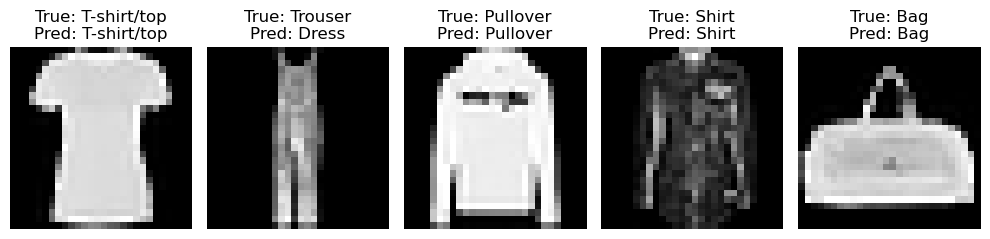

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 加载Fashion MNIST数据集
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
# 数据预处理
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
# 转换为通道维度 (28, 28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
# 转换标签为独热编码
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
# 创建数据集对象
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(60000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)
# 定义模型 - 将模型分为两部分，以便使用不同的优化器
class LowerLayers(tf.keras.Model):
    def __init__(self):
        super(LowerLayers, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        return self.flatten(x)
class UpperLayers(tf.keras.Model):
    def __init__(self):
        super(UpperLayers, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
# 实例化模型部分
lower_layers = LowerLayers()
upper_layers = UpperLayers()
# 为不同层定义不同的优化器 - 下层使用较小的学习率，上层使用较大的学习率
lower_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# 损失函数
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# 评估指标
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')
# 训练步骤
@tf.function
def train_step(images, labels):
    with tf.GradientTape(persistent=True) as tape:
        # 前向传播
        features = lower_layers(images)
        predictions = upper_layers(features)
        loss = loss_fn(labels, predictions)
    # 计算梯度
    lower_gradients = tape.gradient(loss, lower_layers.trainable_variables)
    upper_gradients = tape.gradient(loss, upper_layers.trainable_variables)
    # 应用梯度
    lower_optimizer.apply_gradients(zip(lower_gradients, lower_layers.trainable_variables))
    upper_optimizer.apply_gradients(zip(upper_gradients, upper_layers.trainable_variables))
    # 更新指标
    train_loss(loss)
    train_accuracy(labels, predictions)
    # 删除persistent tape
    del tape
# 验证步骤
@tf.function
def val_step(images, labels):
    features = lower_layers(images)
    predictions = upper_layers(features)
    v_loss = loss_fn(labels, predictions)
    val_loss(v_loss)
    val_accuracy(labels, predictions)
# 训练模型
epochs = 10
for epoch in range(epochs):
    # 重置训练指标
    train_loss = tf.keras.metrics.Mean('train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
    # 训练循环
    for i, (images, labels) in enumerate(train_dataset):
        train_step(images, labels)
        # 每100个批次打印一次中间结果
        if i % 100 == 0:
            print(f'Epoch {epoch + 1}, Iteration {i}, '
                  f'Train Loss: {train_loss.result():.4f}, '
                  f'Train Accuracy: {train_accuracy.result():.4f}')
    # 验证循环
    for images, labels in val_dataset:
        val_step(images, labels)
    # 打印每个轮次结束的结果
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss.result():.4f}, '
          f'Train Accuracy: {train_accuracy.result():.4f}')
    print(f'Val Loss: {val_loss.result():.4f}, '
          f'Val Accuracy: {val_accuracy.result():.4f}\n')
# 可视化一些预测结果
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def plot_predictions():
    # 随机选择一些测试图像
    num_samples = 5
    indices = np.random.choice(len(x_val), num_samples)
    sample_images = x_val[indices]
    sample_labels = y_val[indices]
    # 获取预测结果
    features = lower_layers(sample_images)
    predictions = upper_layers(features)
    predicted_classes = np.argmax(predictions.numpy(), axis=1)
    true_classes = np.argmax(sample_labels, axis=1)
    # 绘制结果
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample_images[i].squeeze(), cmap='gray')
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# 显示预测结果
plot_predictions()